In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from scipy.stats import norm
%matplotlib inline

In [2]:
#######Just downloading the whole dataset and also creating batches

train_transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

Processing...
Done!


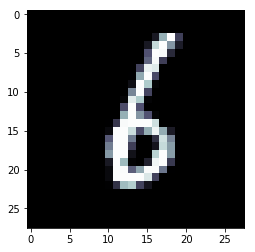

In [3]:
####### Just checking out what the dataset looks like

dataiter = iter(trainloader)
images, labels = dataiter.next()

images.shape
plt.imshow(images[32].squeeze().numpy(), cmap='bone')

In [18]:
########Definition of the architecture of our encoder and decoder model with all the assisting functions

class Net(nn.Module):
    def __init__(self, num_latent):
        super().__init__()
        
        #So here we will first define layers for encoder network
        self.encoder = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1),
                                     nn.MaxPool2d(2, 2),
                                     nn.BatchNorm2d(3),
                                     nn.Conv2d(3, 16, 3, padding=1),
                                     nn.MaxPool2d(2, 2),
                                     nn.BatchNorm2d(16),
                                     nn.Conv2d(16, 16, 3, padding=1))
        
        #These two layers are for getting logvar and mean
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.mean = nn.Linear(128, num_latent)
        self.var = nn.Linear(128, num_latent)
        
        #######The decoder part
        #This is the first layer for the decoder part
        self.expand = nn.Linear(num_latent, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 784)
        self.decoder = nn.Sequential(nn.ConvTranspose2d(16, 16, 3, padding=1),
                                     nn.BatchNorm2d(16),
                                     nn.ConvTranspose2d(16, 3, 8),
                                     nn.BatchNorm2d(3),
                                     nn.ConvTranspose2d(3, 1, 15))
        
    def enc_func(self, x):
        #here we will be returning the logvar(log variance) and mean of our network
        x = self.encoder(x)
        x = x.view([-1, 784])
        x = F.dropout2d(self.fc1(x), 0.5)
        x = self.fc2(x)
        
        mean = self.mean(x)
        logvar = self.var(x)
        return mean, logvar
    
    def dec_func(self, z):
        #here z is the latent variable state
        z = self.expand(z)
        z = F.dropout2d(self.fc3(z), 0.5)
        z = self.fc4(z)
        z = z.view([-1, 16, 7, 7])
        
        out = self.decoder(z)
        out = F.sigmoid(out)
        return out
    
    def get_hidden(self, mean, logvar):
        if self.training:
            print("inside get_hidden")
            std = torch.exp(0.5*logvar)   #So as to get std
            noise = torch.randn_like(mean)   #So as to get the noise of standard distribution
            return noise.mul(std).add_(mean)
        else:
            return mean
    
    def forward(self, x):
        mean, logvar = self.enc_func(x)
        z = self.get_hidden(mean, logvar)
        out = self.dec_func(z)
        return out, mean, logvar

In [19]:
#######This is the custom loss function defined for VAE
### You can even refere to: https://github.com/pytorch/examples/pull/226 

def VAE_loss(out, target, mean, logvar):
    category1 = nn.BCELoss()
    bce_loss = category1(out, target)
    
    print("inside VAE_loss")
    print("out.size()",out.size())
    
    
    
    #We will scale the following losses with this factor
    scaling_factor = out.shape[0]*out.shape[1]*out.shape[2]*out.shape[3]
    
    print("Scaling factor:",scaling_factor)
    assert(False)
    ####Now we are gonna define the KL divergence loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    kl_loss /= scaling_factor
    
    return bce_loss + kl_loss

In [20]:
#####The function which we will call for training our model

def train(trainloader, iters, model, device, optimizer, print_every):
    counter = 0
    for i in range(iters):
        model.train()
        model.to(device)
        for images, _ in trainloader:
            images = images.to(device)
            optimizer.zero_grad()
            out, mean, logvar = model(images)
            print("out:",out)
            print("out.size:",out.size())
            loss = VAE_loss(out, images, mean, logvar)
            loss.backward()
            optimizer.step()
            
        if(counter % print_every == 0):
            model.eval()
            n = 10  # figure with 20x20 digits
            digit_size = 28
            figure = np.zeros((digit_size * n, digit_size * n))

            # Construct grid of latent variable values
            grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
            grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

            counter = 0
            # decode for each square in the grid
            for i, yi in enumerate(grid_x):
                for j, xi in enumerate(grid_y):
                    digit = out[counter].squeeze().cpu().detach().numpy()
                    figure[i * digit_size: (i + 1) * digit_size,
                           j * digit_size: (j + 1) * digit_size] = digit
                    counter += 1

            plt.figure(figsize=(10, 10))
            plt.imshow(figure, cmap='bone')
            plt.show()  

        counter += 1

In [21]:
######Setting all the hyperparameters
##You can change them if you want

iters = 26
num_latent = 8
print_every = 5    #print after every 5 iterations
model = Net(num_latent)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(trainloader, iters, model, device, optimizer, print_every)

inside get_hidden
out: tensor([[[[0.4889, 0.4983, 0.4831,  ..., 0.4894, 0.4895, 0.4897],
          [0.4892, 0.4996, 0.4830,  ..., 0.5040, 0.4915, 0.4910],
          [0.4891, 0.5017, 0.4789,  ..., 0.4820, 0.4885, 0.4931],
          ...,
          [0.4891, 0.4912, 0.4850,  ..., 0.4914, 0.4903, 0.4896],
          [0.4898, 0.4897, 0.4891,  ..., 0.4881, 0.4975, 0.4913],
          [0.4913, 0.4913, 0.4917,  ..., 0.4933, 0.4904, 0.4929]]],


        [[[0.4924, 0.4892, 0.4917,  ..., 0.4897, 0.4922, 0.4919],
          [0.4917, 0.4892, 0.5000,  ..., 0.4870, 0.4914, 0.4918],
          [0.4912, 0.4862, 0.4958,  ..., 0.4865, 0.4864, 0.4890],
          ...,
          [0.4910, 0.4879, 0.5026,  ..., 0.4933, 0.4855, 0.4936],
          [0.4934, 0.4934, 0.4952,  ..., 0.4895, 0.4923, 0.4904],
          [0.4918, 0.4919, 0.4901,  ..., 0.4906, 0.4912, 0.4913]]],


        [[[0.4912, 0.4921, 0.4890,  ..., 0.4945, 0.4921, 0.4915],
          [0.4911, 0.4918, 0.4932,  ..., 0.4872, 0.4868, 0.4901],
          [0.49

/usr/local/anaconda35/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AssertionError: 